<a href="https://colab.research.google.com/github/jason-github1010/ETL-on-data/blob/master/ETA_of_airbnb_analysis_for_CRISP_DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Data Understanding
Our posed business questions are dealing with the types of listings and pricing throughout the year. Looking through the available Airbnb open source data sets at Kaggle, we select the `calendar.csv` [1, 2] and `listings.csv` [3, 4], containing the Airbnb data for the period of interest to us for Los Angeles and New York, respectively. `calendar.csv` contains time series pricing and availability data, while `listings.csv` contains size, location, host, and other information about each listing.

We are going to load data, making formatting changes based on the information available on the data source website at Kaggle for sister data set for Seattle Airbnb listings [5], and then do a quick exploratory analysis to determine whether any cleaning steps should be performed.

### Setup

In [0]:
import numpy as np
import datetime
from scipy import stats

# Setup pandas
import pandas as pd
# pd.plotting.register_matplotlib_converters(explicit=True)  # plotting of dates by pandas
pd.set_option('display.max_columns', 100)  # allow to view all columns in the notebook
# from IPython.display import display

# Setup visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

RANDOM_STATE = 42

###  Load Data
Before we load full datasets let's load a first few lines to save us some headache down the line and make sure we load only the data we need and in the correct format.

In [0]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/D_airbnb')  #change dir

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

# calendar = pd.read_csv('./data/los angeles/calendar.csv', nrows=3)
calendar = pd.read_csv('calendarLA.csv', nrows=3)
calendar


,listing_id,date,available,price
0,109,2019-08-08,t,$127.00
1,72186,2019-10-04,t,$52.00
2,72186,2019-10-03,t,$52.00


In [0]:
# listings = pd.read_csv('./data/new york/listings.csv', nrows=3)
listings = pd.read_csv('listingsNY.csv', nrows=3)
listings

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2515,https://www.airbnb.com/rooms/2515,20181003014905,2018-10-03,Stay at Chez Chic budget room #1,Step into our artistic spacious apartment and ...,-PLEASE BOOK DIRECTLY. NO NEED TO SEND A REQUE...,Step into our artistic spacious apartment and ...,none,NaN,Please no cooking at night but you can warm up...,Subway 2.3.B.C. at 110th street around the cor...,Guests will have their PRIVATE BATHROOM (NOTE:...,We will have a list of Harlem restaurants and ...,no-smoking/please take off your shoes: cleanin...,NaN,NaN,https://a0.muscache.com/im/pictures/d0489e42-4...,NaN,2758,https://www.airbnb.com/users/show/2758,Steph,2008-09-06,"New York, New York, United States",loves to host and welcome travelers from arou...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/2758/profile_...,https://a0.muscache.com/im/users/2758/profile_...,Harlem,3,3,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"New York, NY, United States",Harlem,Harlem,Manhattan,New York,NY,10026,New York,"New York, NY",US,United States,40.799205,-73.953676,t,Apartment,Private room,3,1.0,1,2,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,$59.00,$720.00,"$1,690.00",$0.00,$60.00,2,$39.00,2,21,today,t,10,22,44,310,2018-10-03,173,2008-10-13,2018-09-18,93,9,9,10,9,9,9,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,3,1.42
1,2539,https://www.airbnb.com/rooms/2539,20181003014905,2018-10-03,Clean & quiet apt home by the park,Renovated apt home in elevator building.,"Spacious, renovated, and clean apt home, one b...",Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,If this room is unavailable on your desired da...,Very close to F and G trains and Express bus i...,NaN,NaN,-The security and comfort of all our guests is...,NaN,NaN,https://a0.muscache.com/im/pictures/3949d073-a...,NaN,2787,https://www.airbnb.com/users/show/2787,John,2008-09-07,"New York, New York, United States",Educated professional living in Brooklyn. I l...,NaN,NaN,NaN,t,https://a0.muscache.com/im/pictures/8674565a-7...,https://a0.muscache.com/im/pictures/8674565a-7...,Gravesend,8,8,"['email', 'phone', 'reviews', 'kba']",t,t,"Brooklyn , NY, United States",Kensington,Kensington,Brooklyn,Brooklyn,NY,11218,New York,"Brooklyn , NY",US,United States,40.647486,-73.972370,f,Apartment,Private room,4,1.0,1,3,Real Bed,"{TV,""Cable TV"",Internet,""Wheelchair accessible...",NaN,$149.00,$299.00,$999.00,$100.00,$25.00,1,$25.00,1,730,today,t,25,55,85,360,2018-10-03,8,2015-12-04,2018-07-17,98,10,10,10,10,10,10,f,NaN,NaN,f,f,moderate,f,f,8,

We see that all 4 columns in the **`calendar`** dataset can be useful for our analysis, but we will need to perform the following formatting:
- Import *`date`* as datetime type
- Reformat *`available`* t / f to 1 / 0
- Reformat *`price`*  currency strings to floats
  
**`listings`** is a dataset with a lot more features than **`calendar`**. However, we can reduce the size of the data from the start by selecting only features relevant to our analysis. Since the goal of the analysis is understanding of property sizes and types only we perform the following selections:

**Skip columns with**:
- url links
- textual descriptions - text analysis is beyond the scope of this investigation
- geolocation - we manually add city information based on the source of data
- host information
- data scraping information
- availability related columns - use availability information from the **`calendar`** dataset
- pricing columns - use pricing information from the **`calendar`** dataset
- fees and deposits
- verification and other requirements

With so many columns skipped lets now turn to what features we're keeping.  
  
**Keep columns with**:
- *`id`* - as a key column
- *`experiences offered`* - under the assumptions that any offered experiences my impact the price
- property and room types
- amenities
- property size
- *`guests_included`* (also related to size)

In [0]:
listings_keep_cols = ['id', 'experiences_offered', 'property_type', 'room_type', 'accommodates', 
                      'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet']

In [0]:
def convert_currency(val):
    """Reformat currency string '$x,xxx.xx' to float.
    
    Notes:
        Treat all values that do not start with '$' as invalid and mark as np.nan
    
    Args:
        val (str): string currency value
        
    Returns:
        float: input convertic to numeric value
    """
    if isinstance(val,str) and val.startswith('$'):
      return float(val.replace('$', '').replace(',', ''))
    else:
      return np.nan

def convert_t_f(val):
  if val=='t':
    return 1
  elif val=='f':
    return 0
  else:
    return np.nan


calendar=pd.read_csv('calendarLA.csv',nrows=5,
                     parse_dates=['date'], infer_datetime_format=True,
                     converters={'available': convert_t_f,
                                 'price':convert_currency})
calendar

,listing_id,date,available,price
0,109,2019-08-08,1,127.0
1,72186,2019-10-04,1,52.0
2,72186,2019-10-03,1,52.0
3,72186,2019-10-02,1,52.0
4,72186,2019-10-01,1,52.0


We will use to the utility functions below for formatting prices, percentages, and boolean values.

In [0]:
cities=['LA','NY']

# Initialize dataframes
calendar = pd.DataFrame()
listings = pd.DataFrame()

for city in cities:
  path_cal='calendar'+city+'.csv'  # next time better if put the variable front for any file name
  cal=pd.read_csv(path_cal,
                  parse_dates=['date'], infer_datetime_format=True,
                  converters={'available': convert_t_f,
                              'price': convert_currency})
  cal['city']=city
  calendar=pd.concat([calendar,cal],ignore_index=True)

  path_listings='listings'+city+'.csv'  # next time better if put the variable front for any file name
  li=pd.read_csv(path_listings, usecols=listings_keep_cols, na_values=['none'])
  li['city']=city
  listings=pd.concat([listings,li],ignore_index=True)  

In [0]:
calendar.sample(3, random_state=RANDOM_STATE)
# calendar.describe(include='all')


,listing_id,date,available,price,city
17636486,2297259,2019-05-05,1,900.0,NY
3519324,9450923,2018-10-11,0,NaN,LA
31359690,24783060,2018-12-14,0,NaN,NY


In [0]:
listings.sample(3,random_state=RANDOM_STATE)

,id,experiences_offered,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,city
34383,24836762,NaN,House,Entire home/apt,8,2.0,3.0,4.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",NaN,LA
90450,27396110,NaN,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{Wifi,""Air conditioning"",""Smoke detector""}",NaN,NY
60524,10386936,NaN,Apartment,Private room,2,1.5,1.0,2.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,G...",NaN,NY


We are now ready to load the data sets.

### Examine Data
Now that we have our data loaded and formatted, let's quickly examine it.
#### calendar:

In [0]:
calendar.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34232620 entries, 0 to 34232619
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   listing_id  int64         
 1   date        datetime64[ns]
 2   available   int64         
 3   price       float64       
 4   city        object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.3+ GB


In [0]:
calendar.describe(include='all')

,listing_id,date,available,price,city
count,3.423262e+07,34232620,3.423262e+07,1.339707e+07,34232620
unique,NaN,368,NaN,NaN,2
top,NaN,2018-10-08 00:00:00,NaN,NaN,NY
freq,NaN,93788,NaN,NaN,18264965
first,NaN,2018-10-03 00:00:00,NaN,NaN,NaN
last,NaN,2019-10-05 00:00:00,NaN,NaN,NaN
mean,1.616513e+07,NaN,3.913539e-01,2.114166e+02,NaN
std,8.484408e+06,NaN,4.880533e-01,4.746840e+02,NaN
min,1.090000e+02,NaN,0.000000e+00,0.000000e+00,NaN
25%,9.105638e+06,NaN,0.000000e+00,7.500000e+01,NaN


In [0]:
calendar.isna().mean()

listing_id    0.000000
date          0.000000
available     0.000000
price         0.608646
city          0.000000
dtype: float64

We see that over 60% of entries do not have pricing information. We will deal with the missing values below.
  
Now, let's look at the histogram of dates found in **`calendar`**:

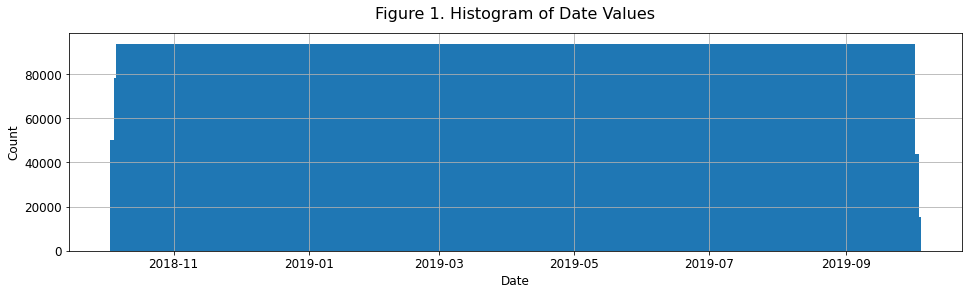

In [0]:
fig1, ax1 = plt.subplots(figsize=(16, 4))
ax1 = calendar.date.hist(bins=calendar.date.nunique(), ax=ax1)
ax1.set_title('Figure 1. Histogram of Date Values', fontsize=16, y=1.04)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Count', fontsize=12);

We see that there appear to be fewer number of listings for dates at the beginning and the end of the date interval (beginning of October of 2018 and beginning of October of 2019). Going back to data source we notice that Los Angeles and New York calendar data sets start and end on slightly different days. We will drop the mismatched dates since they do no influence overall general trends below.
  
Next we examine the distibution of listing prices found in the **`calendar`** dataset.

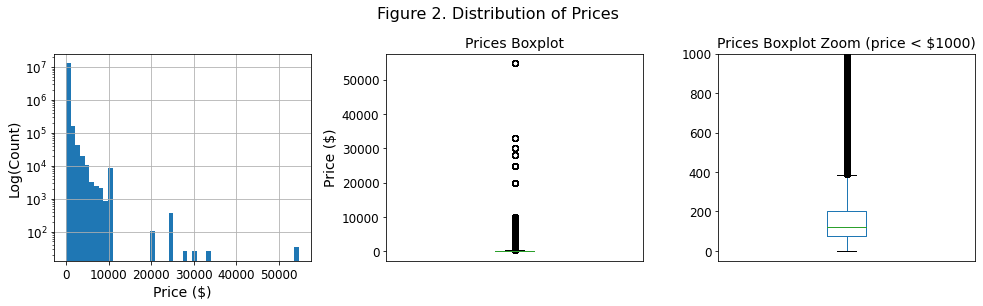

In [0]:
price_zoom = 1000

fig2, axes2 = plt.subplots(1, 3, figsize=(14, 4))

axes2[0] = calendar.price.hist(bins=50, ax=axes2[0], log=True)
axes2[0].set_xlabel('Price ($)')
axes2[0].set_ylabel('Log(Count)')

axes2[1] = calendar.price.plot.box(ax=axes2[1])
axes2[1].set_title('Prices Boxplot')
axes2[1].set_ylabel('Price ($)')

axes2[2], prices_bp = calendar.price.plot.box(return_type='both', ax=axes2[2])
axes2[2].set_title(f'Prices Boxplot Zoom (price < ${price_zoom})')
axes2[2].set_ylim(-50, price_zoom)

# hide x-axis title on boxplots
for ax in axes2[1:]:
    x_axis = ax.axes.get_xaxis()
    x_axis.set_visible(False)

fig2.tight_layout()
fig2.suptitle('Figure 2. Distribution of Prices', y=1.06);

We can from the boxplot of the prices above (center plot) and the zoom of the same plot (right) that there is a large number of outlier prices going into tens of thousands of dollars per night. It makes sense to subdivide the listings into two groups: high and low median priced. We will explore these more closely and deal with them below. 

#### listings:
Now that we have examined the **`calendar`** data, we move onto **`listings`** data:

In [0]:
listings.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93756 entries, 0 to 93755
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   93756 non-null  int64  
 1   experiences_offered  0 non-null      float64
 2   property_type        93756 non-null  object 
 3   room_type            93756 non-null  object 
 4   accommodates         93756 non-null  int64  
 5   bathrooms            93625 non-null  float64
 6   bedrooms             93678 non-null  float64
 7   beds                 93649 non-null  float64
 8   bed_type             93756 non-null  object 
 9   amenities            93756 non-null  object 
 10  square_feet          840 non-null    float64
 11  city                 93756 non-null  object 
dtypes: float64(5), int64(2), object(5)
memory usage: 8.6+ MB


In [0]:
listings.describe(include='all')

,id,experiences_offered,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,city
count,9.375600e+04,0.0,93756,93756,93756.000000,93625.000000,93678.000000,93649.000000,93756,93756,840.000000,93756
unique,NaN,NaN,46,3,NaN,NaN,NaN,NaN,5,86911,NaN,2
top,NaN,NaN,Apartment,Entire home/apt,NaN,NaN,NaN,NaN,Real Bed,{},NaN,NY
freq,NaN,NaN,57126,52873,NaN,NaN,NaN,NaN,92064,403,NaN,50041
mean,1.616309e+07,NaN,NaN,NaN,3.214984,1.279866,1.279511,1.776901,NaN,NaN,850.351190,NaN
std,8.484895e+06,NaN,NaN,NaN,2.288267,0.739376,0.933438,1.461118,NaN,NaN,797.810765,NaN
min,1.090000e+02,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN
25%,9.096861e+06,NaN,NaN,NaN,2.000000,1.000000,1.000000,1.000000,NaN,NaN,400.000000,NaN
50%,1.751503e+07,NaN,NaN,NaN,2.000000,1.000000,1.000000,1.000000,NaN,NaN,725.000000,NaN
75%,2.320256e+07,NaN,NaN,NaN,4.000000,1.000000,1.000000,2.000000,NaN,NaN,1011.000000,NaN


In [0]:
listings.isna().mean()

id                     0.000000
experiences_offered    1.000000
property_type          0.000000
room_type              0.000000
accommodates           0.000000
bathrooms              0.001397
bedrooms               0.000832
beds                   0.001141
bed_type               0.000000
amenities              0.000000
square_feet            0.991041
city                   0.000000
dtype: float64

Note that data for the *`experiences_offered`* feature is missing entirely, so we can safely drop it. Additionally, there is less than 1% of data is available for the *`square_feet`* feature. Since most of the data is missing and there are several other size related listing features, we can drop *`square_feet`* feature as well.

*`bathrooms`*, *`bedrooms`*, and *`beds`* features are missing <0.1% of row values. Since the proportion of missing data is small, we will drop the listings with missing values for these features our analysis.
  
Now, let's examine the value distributions for **`listings`** numerical features:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  This is separate from the ipykernel package so we can avoid doing imports until


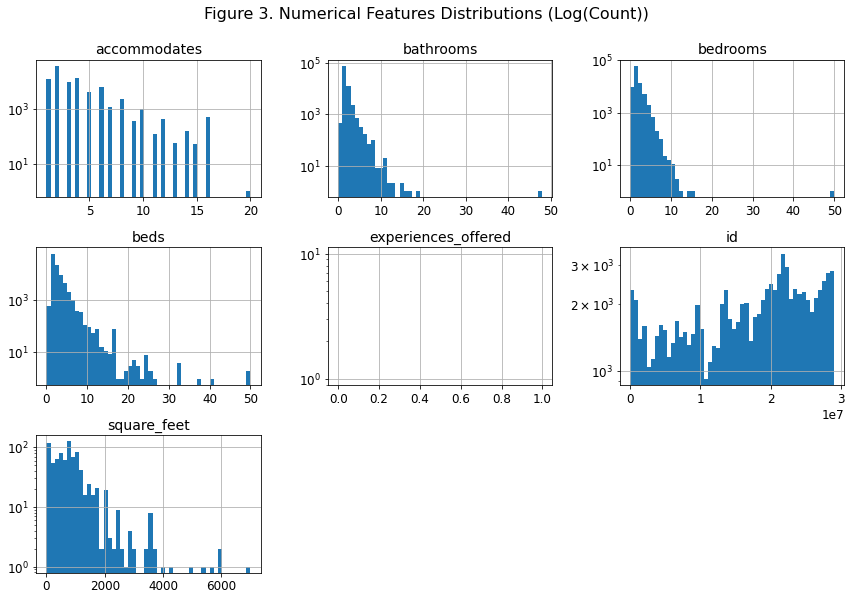

In [0]:
listings.select_dtypes(include=np.number).hist(figsize=(12, 8), bins=50, log=True) # main code to examine numerical features
plt.gcf().suptitle('Figure 3. Numerical Features Distributions (Log(Count))', y=1.04)
plt.gcf().tight_layout();

Note that there are outliers in multiple numerical feature distributions.

Finally, we check the cross-correlations between the numerical features:

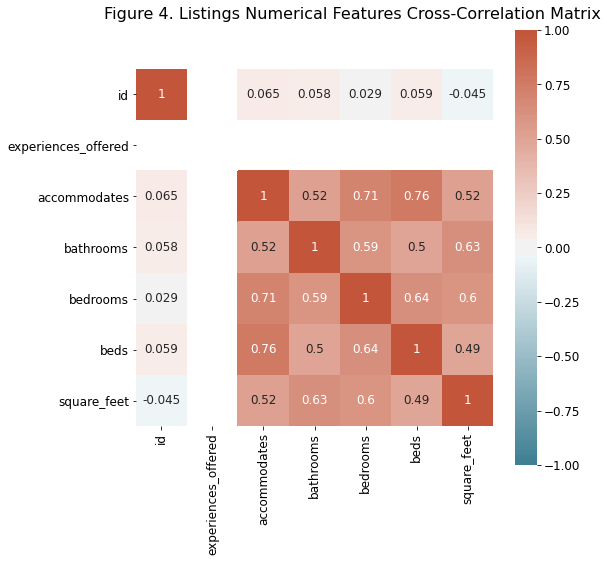

In [0]:
fig4, ax4 = plt.subplots(figsize=(8, 8))
ax4 = sns.heatmap(listings.select_dtypes(include=np.number).corr(), ax=ax4,
                  vmin=-1, vmax=1, center=0, annot=True, square=True,
                  cmap=sns.diverging_palette(220, 20, n=200))
fig4.suptitle('Figure 4. Listings Numerical Features Cross-Correlation Matrix', y=0.92);

The correlation plot above shows that size related features of the listings (accommodates, bedrooms, bathrooms, beds, guests included) are fairly highly correlated. We should be careful dealing with these if we perform any type of regression modeling.
    
Now let's look at our categorical variables:

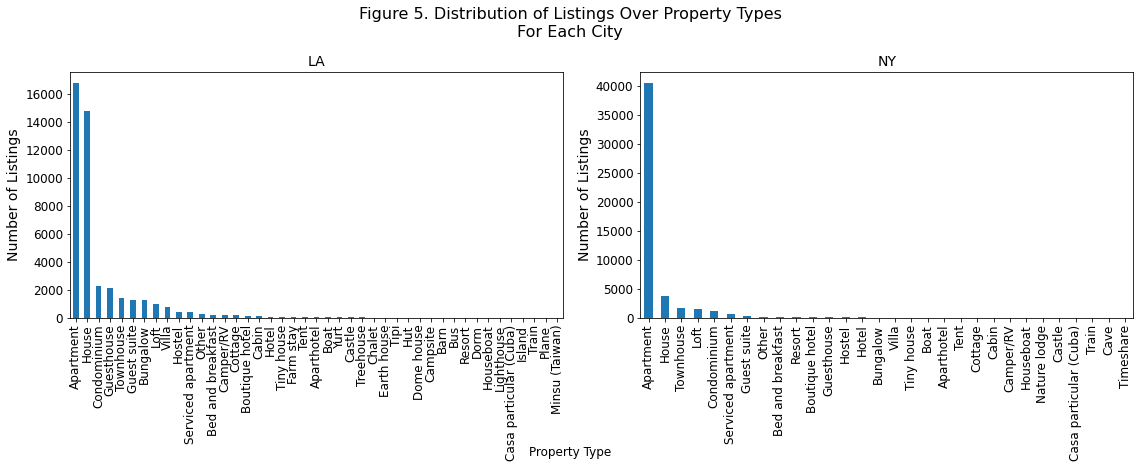

In [0]:
# get sorted by count listings for each property type
# if use .hist, all the axes will run and can't analyse the graph correctly 
property_types = listings.groupby(['city', 'property_type'])\
                         .agg(num_listings=('id', 'count'))\
                         .reset_index()\
                         .sort_values('num_listings', ascending=False)


fig5, ax5 = plt.subplots(1, 2, figsize=(16, 6))

for ax, city in zip(ax5, cities):
    property_types[property_types.city==city].plot(x='property_type', y='num_listings',
                                                   kind='bar', ax=ax, legend=False);
    ax.set_title(city)
    ax.set_ylabel('Number of Listings')
ax5[0].set_xlabel('') 
ax5[1].set_xlabel('')
fig5.suptitle(f'Figure 5. Distribution of Listings Over Property Types\n'
              f'For Each City', y=1.08)
fig5.text(0.5, 0.04, 'Property Type', ha='center')
fig5.tight_layout();

**Figure 5** shows that most listings types have very few associated listings. Thus, when performing analysis, we should focus on the top represented listing types.

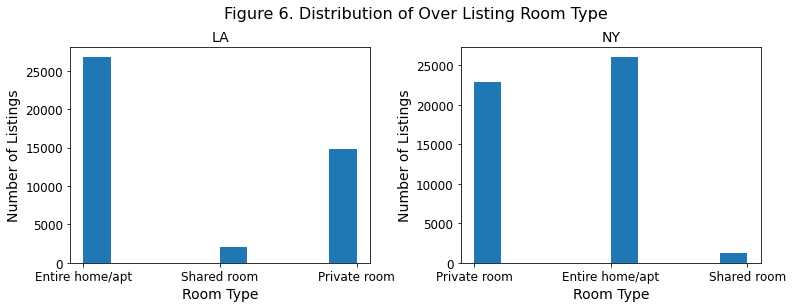

In [0]:
# easiest way to plot histogram
#listings.room_type.sort_index().hist(by=listings.city, figsize=(16,6))
listings.room_type.sort_index().hist(by=listings.city, xrot=0.1, figsize=(12, 4))
for ax in plt.gcf().axes:
    ax.set_xlabel('Room Type')
    ax.set_ylabel('Number of Listings')
plt.gcf().suptitle('Figure 6. Distribution of Over Listing Room Type', y=1.04);

#Another way to plot ( more comprehensie and apply to many use cases)
# room_types=listings.groupby(['city', 'room_type'])\
#                   .agg(num_listings=('id','count'))\
#                   .reset_index()\
#                   .sort_values('num_listings',ascending=False)

# fig6,ax6= plt.subplots(1,2,figsize=(16,6))

# for ax, city in zip(ax6,cities):
#   room_types[room_types.city==city].plot(x='room_type', y='num_listings', kind='bar', ax=ax, legend=False)                       



In [0]:
listings.amenities.head()

0    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
1    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
2                                                   {}
3    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
4    {TV,"Cable TV",Internet,Wifi,Kitchen,"Free par...
Name: amenities, dtype: object

We must process the data in the *`amenities`* column manually since it is not standardized with each entry contains a variable list of amenities. 

### Data Understanding Summary
**`calendar`**
- 34,232,620 entries of 5 variables
- Over 60\% of *`price`* entries are missing values 
- Non-normal distribution of prices skewed right with far outliers above \$20,000
- Mismatched dates at *`date`* tailends between Los Angeles and New York where not all listings have entries  

**`listings`**
- 93804 entries of 12 variables
- *`experience_offered`* feature is missing all values
- *`square_feet`* feature is missing > 99\% of all values
- *`bathrooms`, `bedrooms`, `beds`* features are missing < 0.15\% of values
- All numerical features are right-skewed with far outlier values
- Significant cross-correlation (> 0.5) between *`accommodates`, `bathrooms`, `bedrooms`, `beds`*
- String encoded *`amenities`* feature contains a mixed-formatted list of keywords and phrases

## Data Preparation 

Now that we have understanding of the types and quality of loaded data, we are going to prepare it for our analysis.

Before doing data cleaning and manipulation we save a copy of the raw data in case we mess up.

In [0]:
# Backup copy of raw datasets in case we mess up
cal_raw = calendar.copy()
listings_raw = listings.copy()

### Missing and/or mismatched values
When preparing our data for analysis and modeling we start by dealing with missing or unusable values.
####  `calendar`

Let's start by cleaning up the mismatched dates between Los Angeles and New York discussed above.

In [0]:
date_counts=calendar.groupby('date')['date'].agg('count')

drop_dates = date_counts[date_counts < date_counts.max()].index.values
print('Mismatched dates between Los Angeles and New York calendar datasets:\n', drop_dates)

Mismatched dates between Los Angeles and New York calendar datasets:
 ['2018-10-03T00:00:00.000000000' '2018-10-04T00:00:00.000000000'
 '2018-10-05T00:00:00.000000000' '2019-10-03T00:00:00.000000000'
 '2019-10-04T00:00:00.000000000' '2019-10-05T00:00:00.000000000']


In [0]:
calendar = calendar[~calendar.date.isin(drop_dates)]

Now let's look at the calendar price missing values more closely.

In [0]:
calendar[calendar.price.isna()].sample(5, random_state=RANDOM_STATE)

,listing_id,date,available,price,city
33491772,28014733,2019-01-02,0,NaN,NY
14857619,27984258,2019-08-06,0,NaN,LA
12413196,24680083,2019-06-20,0,NaN,LA
23889425,13796187,2019-01-05,0,NaN,NY
33012739,27373599,2018-12-11,0,NaN,NY


It appears that all missing price values are corresponding to unavailability of listing on that date encoded as `available=0`. Let's check if it is true for every missing price entry.

In [0]:
# check aif missing any listings were available for dates where price is missing
is_missing_price_always_unavailbale = pd.Series((calendar.available == 0) == (calendar.price.isna())).all()
print('All observations with missing prices correspond to unavailability (available=0) and vice versa' 
      if is_missing_price_always_unavailbale
      else 'Some observations with missing prices are listed as available')

All observations with missing prices correspond to unavailability (available=0) and vice versa


Note that listing availability maps 1:1 with missing price data. Although, we have to be careful about dropping missing price rows since dropped availability data may skew seasonal and cumulative availability patterns, listings that are not available for the entire data time interval do not provide us with any trend information for this period and, thus, can be dropped.

In [0]:
# Sum listing availability for each listing id
listing_availability = calendar.groupby(['listing_id']).agg(total_available=('available', 'sum'))\
        .reset_index()

# Find listing ids with 0 total availability
never_available_listings = listing_availability[listing_availability.total_available == 0]\
        .listing_id.values

never_available_listings

array([    2864,     5172,     5203, ..., 28985951, 29012631, 29036305])

In [0]:
print(f'Found {len(never_available_listings)} listings '
      f'({100.0 * len(never_available_listings) / len(calendar.listing_id.unique()):.2f}% of total) '
      f'that are never available.')

Found 26330 listings (28.07% of total) that are never available.


We will drop these listings from **`calendar`**.

In [0]:
# drop never available listings from calendar data set
calendar = calendar[~calendar.listing_id.isin(never_available_listings)]

In [0]:
print(f'Cleaned calendar contains {len(calendar.index)} daily prices for'
      f' {calendar.listing_id.nunique()} unique listings.')

Cleaned calendar contains 24419796 daily prices for 67458 unique listings.


In [0]:
calendar_listing_ids = calendar.listing_id.unique()
calendar_listing_ids

array([     109,    72186,    25445, ..., 28982976, 28983635, 28983774])

#### `listings`
After cleaning up the **`calendar`** dataset, let's move on to **`listings`**.

Since we use the **`listings`** data set to model average prices calculated in **`calendar`** data set, we will drop all listings for which calculated pricing data is not available by merging average listing price data with **`listings`** data:

In [0]:
price_ave_df=calendar.groupby('listing_id').price.mean()\
                     .reset_index().rename(columns={'listing_id':'id', 'price':'price_ave'})

price_ave_df

,id,price_ave
0,109,126.157895
1,344,175.500000
2,2404,85.000000
3,2515,82.345161
4,2539,154.697222
...,...,...
67453,29041476,19.078652
67454,29042858,60.736842
67455,29042908,60.000000
67456,29046064,109.000000


In [0]:
listings = price_ave_df.merge(listings, on='id')
# listings3=pd.merge(listings, price_ave_df, on='id')  another way
listings

,id,price_ave,experiences_offered,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,city
0,109,126.157895,NaN,Condominium,Entire home/apt,6,2.0,2.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,LA
1,344,175.500000,NaN,House,Entire home/apt,6,1.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,LA
2,2404,85.000000,NaN,Apartment,Shared room,1,NaN,1.0,1.0,Airbed,{},NaN,LA
3,2515,82.345161,NaN,Apartment,Private room,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,NY
4,2539,154.697222,NaN,Apartment,Private room,4,1.0,1.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wheelchair accessible...",NaN,NY
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67413,29041476,19.078652,NaN,House,Shared room,1,3.0,1.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Smoking a...",NaN,LA
67414,29042858,60.736842,NaN,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Free parking on premises"",Heating,Wa...",NaN,LA
67415,29042908,60.000000,NaN,Condominium,Shared room,1,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",NaN,LA
67416,29046064,109.000000,NaN,Condominium,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",NaN,LA


For convenience we set *`id`* column as index since it will not be used as a variable in our models.

In [0]:
listings = listings.set_index('id')
listings

,price_ave,experiences_offered,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,city
id,,,,,,,,,,,,
109,126.157895,NaN,Condominium,Entire home/apt,6,2.0,2.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,LA
344,175.500000,NaN,House,Entire home/apt,6,1.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,LA
2404,85.000000,NaN,Apartment,Shared room,1,NaN,1.0,1.0,Airbed,{},NaN,LA
2515,82.345161,NaN,Apartment,Private room,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,NY
2539,154.697222,NaN,Apartment,Private room,4,1.0,1.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wheelchair accessible...",NaN,NY
...,...,...,...,...,...,...,...,...,...,...,...,...
29041476,19.078652,NaN,House,Shared room,1,3.0,1.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Smoking a...",NaN,LA
29042858,60.736842,NaN,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Free parking on premises"",Heating,Wa...",NaN,LA
29042908,60.000000,NaN,Condominium,Shared room,1,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",NaN,LA


Now, let's drop the columns with over 99% of missing values found in **Data Understanding** section above:

In [0]:
# drop columns with > 99% missing values
listings = listings.drop(columns=['experiences_offered', 'square_feet'])

Now we drop rows with missing values for columns with total of < 0.1% of missing data (see **Section 2.2. listings** above):

In [0]:
listings = listings.dropna(subset=['bathrooms', 'bedrooms', 'beds'], axis=0, how='any')

In [0]:
# check for missing data
listings.isna().sum()

price_ave        0
property_type    0
room_type        0
accommodates     0
bathrooms        0
bedrooms         0
beds             0
bed_type         0
amenities        0
city             0
dtype: int64

In [0]:
print(f'Our cleansed datasets are:\n'
      f'Calendar dataset with {len(calendar.index)} observations of '
      f'{len(calendar.columns)} features for dates ranging from '
      f'{calendar.date.min().date()} to {calendar.date.max().date()}.\n'
      f'Listings dataset of {len(listings.index)} unique listing id\'s '
      f'with {len(listings.columns)} features.')

Our cleansed datasets are:
Calendar dataset with 24419796 observations of 5 features for dates ranging from 2018-10-06 to 2019-10-02.
Listings dataset of 67224 unique listing id's with 10 features.


### Feature Engineering
In this section we generate features useful for exploratory analysis and modeling.
#### Listing price bins

Let's address the outliers in the distribution of listing prices (see **Figure 2** above).

In [0]:
outlier_prices = [flier.get_ydata() for flier in prices_bp["fliers"]][0]  # get outlier values from boxplot
print(f'Outlier prices threshold is ${outlier_prices.min():.2f}')

Outlier prices threshold is $388.00


We can see that there are a lot of outliers above $388.00 in the price distribution. We need to determine whether these outliers are caused by differences in typical price listings with a small subset of expensive listings appearing as outliers, or whether some list prices are true outliers. We can do that by examining the **median** prices for each listing and splitting off the high-priced listings. Note that because we may have outliers, we use median price per listing rather than the mean, since median is less sensitive to potential outliers.
  
While we're doing summary statistics, we will also look at mean, min, max, percent range ($100 \% \cdot range / mean $), and overall availability (using count) for each listing.

In [0]:
price_agg = calendar.groupby(['listing_id', 'city'])\
                    .agg(days_available=('price', 'count'),
                         price_median=('price', 'median'),
                         price_mean=('price', 'mean'),
                         price_min=('price', 'min'),
                         price_max=('price', 'max')).reset_index()

# Price percent range for a given listing
price_agg['price_prange'] = 100.0 * (price_agg.price_max - price_agg.price_min) / price_agg.price_mean

In [0]:
price_agg.sample(3, random_state=RANDOM_STATE)

,listing_id,city,days_available,price_median,price_mean,price_min,price_max,price_prange
54824,25867889,LA,36,220.0,220.000000,220.0,220.0,0.000000
38576,20750988,LA,66,325.0,325.166667,325.0,331.0,1.845208
48385,23731257,LA,353,189.0,189.000000,189.0,189.0,0.000000


Before proceeding with outlier median price listings let's briefly look at the changes in price for a given listing by looking at the listing price percent range, *`price_prange`*.

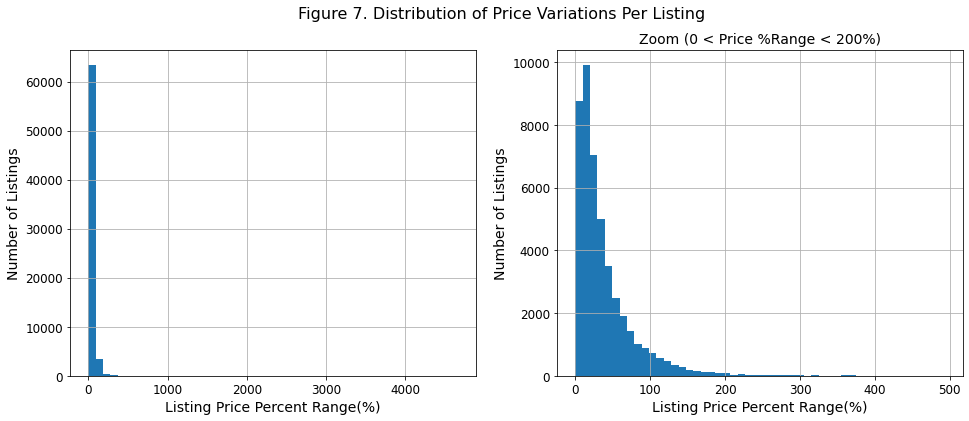

In [0]:
fig7, ax7= plt.subplots(1,2,figsize=(16,6))

ax7[0]=price_agg.price_prange.hist(ax=ax7[0], bins=50)
ax7[0].set_ylabel('Number of Listings')
ax7[0].set_xlabel('Listing Price Percent Range(%)')

ax77[1]=price_agg.price_prange[(price_agg.price_prange>0) & (price_agg.price_prange<500)].hist( ax=ax7[1], bins=50)
ax7[1].set_ylabel('Number of Listings')
ax7[1].set_xlabel('Listing Price Percent Range(%)')
ax7[1].set_title('Zoom (0 < Price %Range < 200%)')

fig7.suptitle('Figure 7. Distribution of Price Variations Per Listing');


In [0]:
# proportion of listings with fixed price throughout the year
print(f'{100 * (price_agg.price_prange==0).mean():.2f}% of listings have fixed price throughout the year')

# Most frequent price % range for non-fixed price listings
print(f'Most frequent price range for non-fixed price listings is '
      f'{price_agg[price_agg.price_prange > 0].price_prange.mode()[0]:.2f}%')

# Median price % range for non-fixed price listings
print(f'Median price range for non-fixed price listings is '
      f'{price_agg[price_agg.price_prange > 0].price_prange.median():.2f}%')

# Mean price % range for non-fixed price listings
print(f'Mean price range for non-fixed price listings is '
      f'{price_agg[price_agg.price_prange > 0].price_prange.mean():.2f}%')

32.51% of listings have fixed price throughout the year
Most frequent price range for non-fixed price listings is 14.42%
Median price range for non-fixed price listings is 24.88%
Mean price range for non-fixed price listings is 39.08%


From **Figure 7** we note that a large proportion of listings (~32.5\%) do not change prices througout the year. This is a significant proportion of all listings and may even impact the overall weekend vs. weekday price trends, but we'll get to these a little later.

Now let's plot a histogram of listing median prices and mark outlier threshold prices found using interquantile range (IQR) method. Typical outlier boundary (Tukey fences) value is $1.5 \cdot IQR$. We can use $3 \cdot IQR$ to find "far" outliers since our dataset is large and we can expect to see a broad range of prices.
  
The utility function to find outlier boundary is below.

In [0]:
def iqr_outlier_boundary(arr, k=1.5):
    """Return interquantile range outlier (IQR) thresholds of the input numeric array 
    
    IQR = Qutntile 3 - Quantile 1
    lower threshold = Quntile 1 - k * IQR (outliers lie below lower threshold)
    upper threshold = Quantile 3 + k * IQR (outliers lie above upper threshold)
    
    Args:
        arr [num]: numeric array
        k (float): interquantile box length multiplier.  (Standard Tukey uses k=1.5)
        
    Returns:
        lower outlier threshold, upper outlier threshold
    """
    q1 = arr.quantile(0.25)
    q3 = arr.quantile(0.75)
    iqr = q3 - q1
    
    return (q1 - k * iqr, q3 + k * iqr)

In [0]:
# We do not need a lower outlier boundary since we're looking at high priced outliers
_, outlier_iqr1_5 = iqr_outlier_boundary(price_agg.price_median, 1.5)
_, outlier_iqr3 = iqr_outlier_boundary(price_agg.price_median, 3)

print(f'Tukey outlier boundary (k=1.5) is ${outlier_iqr1_5:.2f}')
print(f'Far outlier boundary (k=3) is ${outlier_iqr3:.2f}')

Tukey outlier boundary (k=1.5) is $379.50
Far outlier boundary (k=3) is $564.00


Let's visualize where the outliers are in our distribution.

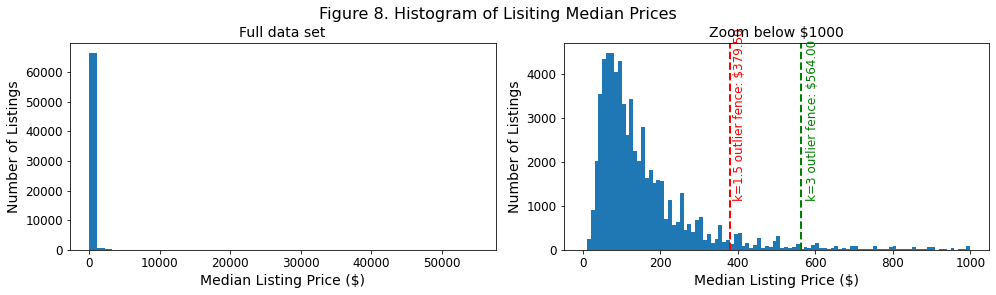

In [0]:
zoom_price = 1000  # Change graph scale to zoom in on the area of interest

fig8, ax8 = plt.subplots(1, 2, figsize=(14, 4))

# Plot full data set
ax8[0] = price_agg.price_median.hist(bins=50, ax=ax8[0], grid=False)
ax8[0].set_title ('Full data set')

# Plot subset of data with median price < zoom price
ax8[1] = price_agg[price_agg.price_median < zoom_price].price_median.hist(ax=ax8[1], bins=100, grid=False)
ax8[1].set_title(f'Zoom below ${zoom_price}')

# Add axis labels
for ax in ax8:
    ax.set_ylabel('Number of Listings')
    ax.set_xlabel('Median Listing Price ($)')

# Add marker for outlier thresholds
transform=ax8[1].get_xaxis_transform()
for k, cut, color in zip([1.5, 3], [outlier_iqr1_5, outlier_iqr3], ['r', 'g']):
    ax8[1].axvline(x=cut, color=color, linestyle='dashed', linewidth=2)
    plt.text(1.02 * cut, 0.25, f'k={k} outlier fence: ${cut:.2f}', 
             transform=transform, rotation=90, color=color)

fig8.suptitle('Figure 8. Histogram of Lisiting Median Prices', y=1.02)
fig8.tight_layout();

Looking at the zoom of the histogram of listing median prices on the right, we see that standard $1.5 \cdot IQR$ cutoff leaves a good bit of the median price distribution tail, so we choose outlier cutoff to be $3 \cdot IQR$ (although either fence value is reasonable for our large sample size)  
  
Let's create a feature indicating whether listing belongs to low or high median price bin.

In [0]:
outlier_threshold = outlier_iqr3
price_bins = [f'median <= ${outlier_threshold}', f'median > ${outlier_threshold}']

In [0]:
# Listing_ids for listings with median price above outlier threshold
low_priced_listing_ids = price_agg[price_agg.price_median <= outlier_threshold].listing_id.values
high_priced_listing_ids = price_agg[price_agg.price_median > outlier_threshold].listing_id.values

# Add column indicating high/low priced listing bin in calendar and price_summary
calendar['listing_price_bin'] = np.where(calendar.listing_id.isin(low_priced_listing_ids), 
                                         price_bins[0], price_bins[1])
price_agg['listing_price_bin'] = np.where(price_agg.listing_id.isin(low_priced_listing_ids), 
                                          price_bins[0], price_bins[1])

print(f'There are {len(high_priced_listing_ids)} high priced listings '
      f'({100.0 * len(high_priced_listing_ids) / len(price_agg.index):.2f}% total) '
      f'with median price above ${outlier_threshold}')

There are 2738 high priced listings (4.06% total) with median price above $564.0


In [0]:
# Show sample of data with high_priced feature
price_agg.groupby('listing_price_bin').apply(lambda x: x.sample(random_state=RANDOM_STATE))

,,listing_id,city,days_available,price_median,price_mean,price_min,price_max,price_prange,listing_price_bin
listing_price_bin,,,,,,,,,,
median <= $564.0,60619,27552275,LA,326,149.0,151.748466,109.0,179.0,46.128967,median <= $564.0
median > $564.0,12067,6453112,LA,360,1999.0,2070.427778,1999.0,3000.0,48.347497,median > $564.0


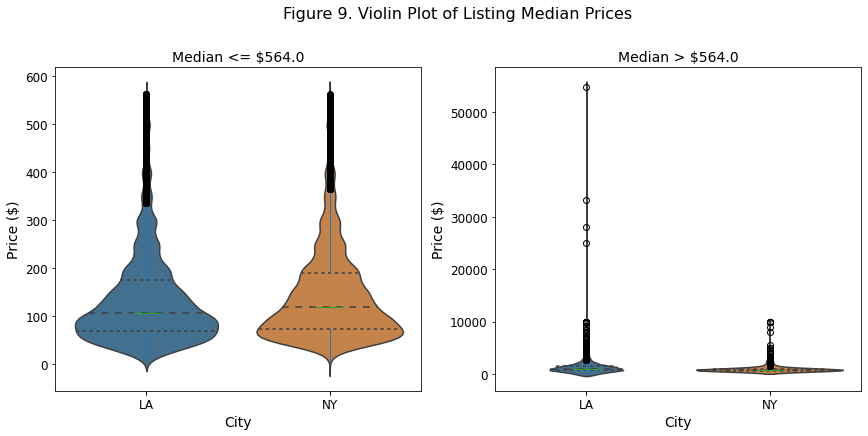

In [0]:
# Box plot 2 data subsets side to see outliers for each subset
fig9, ax9 = plt.subplots(1, 2, figsize=(14,6))

for ax, price_bin in zip(ax9, price_bins):
    df = price_agg[price_agg.listing_price_bin==price_bin]
    sns.violinplot(ax=ax, x='city', y='price_median', data= df, order=cities,
                   saturation=0.5, inner='quartile')
    df.boxplot(ax=ax, column='price_median', by='city', 
               grid=False, showbox=False, showcaps=False, positions=np.array([0, 1]))
    ax.set_title(price_bin.capitalize())
    ax.set_ylabel('Price ($)')
    ax.set_xlabel('City')
fig9.suptitle('Figure 9. Violin Plot of Listing Median Prices', y=1.04);

We see that the there are 4 far-outlier listings in Los Angeles with median prices above \$20,000. For the purpose of examining **general** trends we will **drop** these listings from our analysis, but just to satisfy our curiosity let's very briefly examine them.

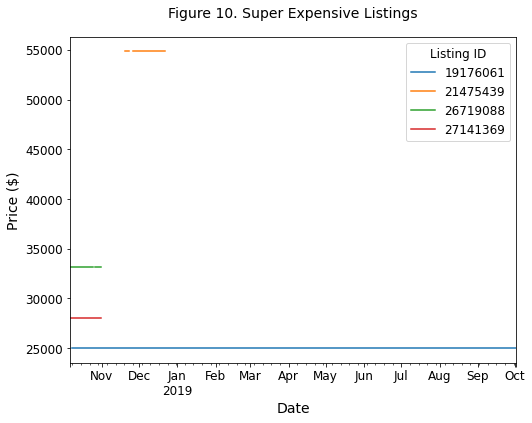

In [0]:
# Get super expensive listing ids
super_expensive_listing_ids = price_agg[price_agg.price_median > 20000].listing_id

# Time plot of prices throughout the year for super expensive listings
fig10, ax10 = plt.subplots(figsize=(8, 6))
for listing_id in super_expensive_listing_ids:
    calendar[calendar.listing_id==listing_id].plot(x='date', y='price', ax=ax10, label=listing_id,
                                                   legend=False)
ax10.set_title('Figure 10. Super Expensive Listings', y=1.04)
ax10.set_xlabel('Date')
ax10.set_ylabel('Price ($)')
ax10.legend(title='Listing ID');

From our plot and listing descriptions above we can say that:
- Listing with id **19176061** is for a large villa on a 3-acre property for up to 16 person occupancy that was available for the entire year at a constant price of \$25,000  
- The other three listings (**27141369**, **26719088**, and **21475439**) are for smaller apartments and are likely mispriced 100x (misplaced coma or period). These listings were only available for one month out of the year further supporting our theory of incorrect pricing

In [0]:
# Drop extreme price outlier listings
calendar = calendar[~calendar.listing_id.isin(super_expensive_listing_ids)]
price_agg = price_agg[~price_agg.listing_id.isin(super_expensive_listing_ids)]

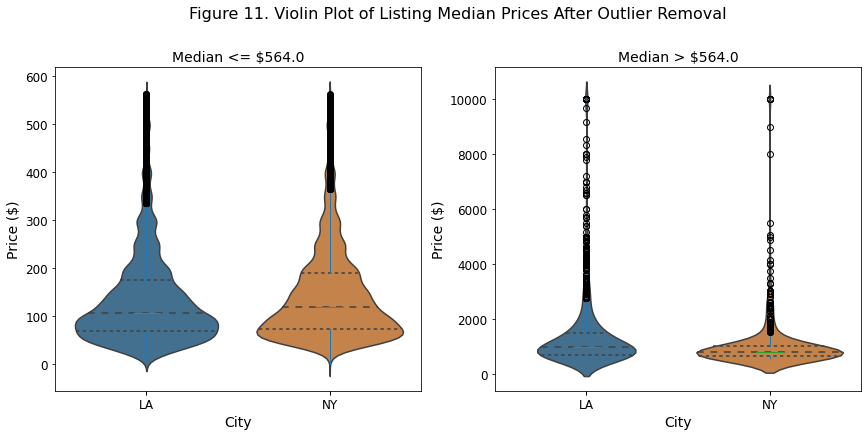

In [0]:
# Box plot 2 data subsets side to see outliers for each subset
fig11, ax11 = plt.subplots(1, 2, figsize=(14,6))

for ax, price_bin in zip(ax11, price_bins):
    df = price_agg[price_agg.listing_price_bin==price_bin]
    sns.violinplot(ax=ax, x='city', y='price_median', data= df, order=cities,
                   saturation=0.5, inner='quartile')
    df.boxplot(ax=ax, column='price_median', by='city', 
               grid=False, showbox=False, showcaps=False, positions=np.array([0, 1]))
    ax.set_title(price_bin.capitalize())
    ax.set_ylabel('Price ($)')
    ax.set_xlabel('City')
fig11.suptitle('Figure 11. Violin Plot of Listing Median Prices After Outlier Removal', y=1.04);

#### Amenities
  
However, we have encoded the remaining categorical feature *`amenities`* as string type on data loading. This string column contains a list of amenities, separated by commas, enclosed in curly brackets and sometime in quotation marks. As encoded, this feature will have too many overlapping levels and will not be very useful in our analysis. Therefore, we parse this column in order to separate and standardize the amenities feature set and indicate which listings include what types of amenities. 

We achieve this by first converting the strings to lowercase, strip out quotations and parenthesis. Next we split the formatted string into a list of individual amenities and represent them as a **pandas.Series**. Next, we stack the series and create a dataframe of amenities dummy variables by computing cross tabulation of the resultant factors. Each unique amenity is represented in a column name and each listing in a row. Values of **1** in cell *(i, j)* indicates that listing *i* contains amenity *j*, while value of **0** indicates that this amenity is not mentioned.

In [0]:
# Process amenities
amenities_df = listings.amenities.str.lower().str.strip('}{').str.replace('"', '')\
                                 .str.split(',').apply(pd.Series)\
                                 .stack().rename('value').reset_index() 
amenities_df = pd.crosstab(amenities_df.id, amenities_df.value).drop(columns=[''])

amenities_df.columns = [x.strip().replace(' ', '_') for x in amenities_df.columns.values]
amenities_df.head()

,toilet,24-hour_check-in,accessible-height_bed,accessible-height_toilet,air_conditioning,air_purifier,alfresco_bathtub,amazon_echo,baby_bath,baby_monitor,babysitter_recommendations,balcony,bath_towel,bathroom_essentials,bathtub,bathtub_with_bath_chair,bbq_grill,beach_essentials,beach_view,beachfront,bed_linens,bedroom_comforts,bidet,body_soap,breakfast,breakfast_table,brick_oven,building_staff,buzzer/wireless_intercom,cable_tv,carbon_monoxide_detector,cat(s),ceiling_fan,ceiling_hoist,central_air_conditioning,changing_table,children’s_books_and_toys,children’s_dinnerware,cleaning_before_checkout,coffee_maker,convection_oven,cooking_basics,crib,day_bed,disabled_parking_spot,dishes_and_silverware,dishwasher,dog(s),doorman,double_oven,...,roll-in_shower,room-darkening_shades,safety_card,sauna,self_check-in,shampoo,shared_gym,shared_hot_tub,shared_pool,shower_chair,single_level_home,ski-in/ski-out,smart_lock,smart_tv,smoke_detector,smoking_allowed,soaking_tub,sound_system,stair_gates,stand_alone_steam_shower,standing_valet,steam_oven,step-free_access,stove,suitable_for_events,sun_loungers,swimming_pool,table_corner_guards,tennis_court,terrace,toilet_paper,touchless_faucets,translation_missing:_en.hosting_amenity_49,translation_missing:_en.hosting_amenity_50,tv,walk-in_shower,warming_drawer,washer,washer_/_dryer,waterfront,well-lit_path_to_entrance,wheelchair_accessible,wide_clearance_to_bed,wide_clearance_to_shower,wide_doorway,wide_entryway,wide_hallway_clearance,wifi,window_guards,wine_cooler
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
109,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
344,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2515,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2539,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2595,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Let's examine what our amenities features look like:

In [0]:
amenities_df.describe()

,toilet,24-hour_check-in,accessible-height_bed,accessible-height_toilet,air_conditioning,air_purifier,alfresco_bathtub,amazon_echo,baby_bath,baby_monitor,babysitter_recommendations,balcony,bath_towel,bathroom_essentials,bathtub,bathtub_with_bath_chair,bbq_grill,beach_essentials,beach_view,beachfront,bed_linens,bedroom_comforts,bidet,body_soap,breakfast,breakfast_table,brick_oven,building_staff,buzzer/wireless_intercom,cable_tv,carbon_monoxide_detector,cat(s),ceiling_fan,ceiling_hoist,central_air_conditioning,changing_table,children’s_books_and_toys,children’s_dinnerware,cleaning_before_checkout,coffee_maker,convection_oven,cooking_basics,crib,day_bed,disabled_parking_spot,dishes_and_silverware,dishwasher,dog(s),doorman,double_oven,...,roll-in_shower,room-darkening_shades,safety_card,sauna,self_check-in,shampoo,shared_gym,shared_hot_tub,shared_pool,shower_chair,single_level_home,ski-in/ski-out,smart_lock,smart_tv,smoke_detector,smoking_allowed,soaking_tub,sound_system,stair_gates,stand_alone_steam_shower,standing_valet,steam_oven,step-free_access,stove,suitable_for_events,sun_loungers,swimming_pool,table_corner_guards,tennis_court,terrace,toilet_paper,touchless_faucets,translation_missing:_en.hosting_amenity_49,translation_missing:_en.hosting_amenity_50,tv,walk-in_shower,warming_drawer,washer,washer_/_dryer,waterfront,well-lit_path_to_entrance,wheelchair_accessible,wide_clearance_to_bed,wide_clearance_to_shower,wide_doorway,wide_entryway,wide_hallway_clearance,wifi,window_guards,wine_cooler
count,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,...,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000,67224.000000
mean,0.021971,0.129849,0.043496,0.038007,0.818785,0.000327,0.000149,0.000565,0.009818,0.003912,0.022016,0.001294,0.008747,0.009030,0.109157,0.002826,0.087201,0.025839,0.000417,0.006367,0.336889,0.009030,0.000119,0.010978,0.111359,0.002306,0.000074,0.033783,0.132021,0.312374,0.734470,0.030198,0.002187,0.000015,0.000997,0.006233,0.046427,0.017226,0.033083,0.296888,0.001205,0.304623,0.024515,0.000550,0.010086,0.334791,0.178076,0.049774,0.029870,0.000417,...,0.004254,0.050116,0.149753,0.000060,0.323337,0.767166,0.000045,0.000372,0.000461,0.002276,0.082783,0.000625,0.033515,0.003407,0.891973,0.064263,0.001145,0.001830,0.006887,0.000104,0.000045,0.000015,0.256813,0.314456,0.049670,0.001264,0.000015,0.002916,0.000015,0.001413,0.008747,0.000074,0.151300,0.190230,0.755727,0.002306,0.000193,0.593017,0.000283,0.006173,0.086145,0.045371,0.054638,0.021956,0.143044,0.046695,0.058298,0.976928,0.018937,0.000580
std,0.146591,0.336140,0.203973,0.191215,0.385199,0.018088,0.012196,0.023769,0.098599,0.062426,0.146736,0.035952,0.093116,0.094594,0.311839,0.053089,0.282131,0.158656,0.020405,0.079538,0.472650,0.094594,0.010908,0.104201,0.314579,0.047963,0.008624,0.180670,0.338516,0

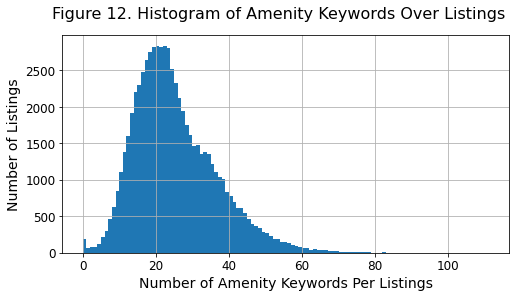

In [0]:
fig12, ax12 = plt.subplots(figsize=(8, 4))

amenities_df.sum(axis=1).hist(ax=ax12, bins=amenities_df.sum(axis=1).max())
ax12.set_xlabel('Number of Amenity Keywords Per Listings')
ax12.set_ylabel('Number of Listings')
fig12.suptitle('Figure 12. Histogram of Amenity Keywords Over Listings');

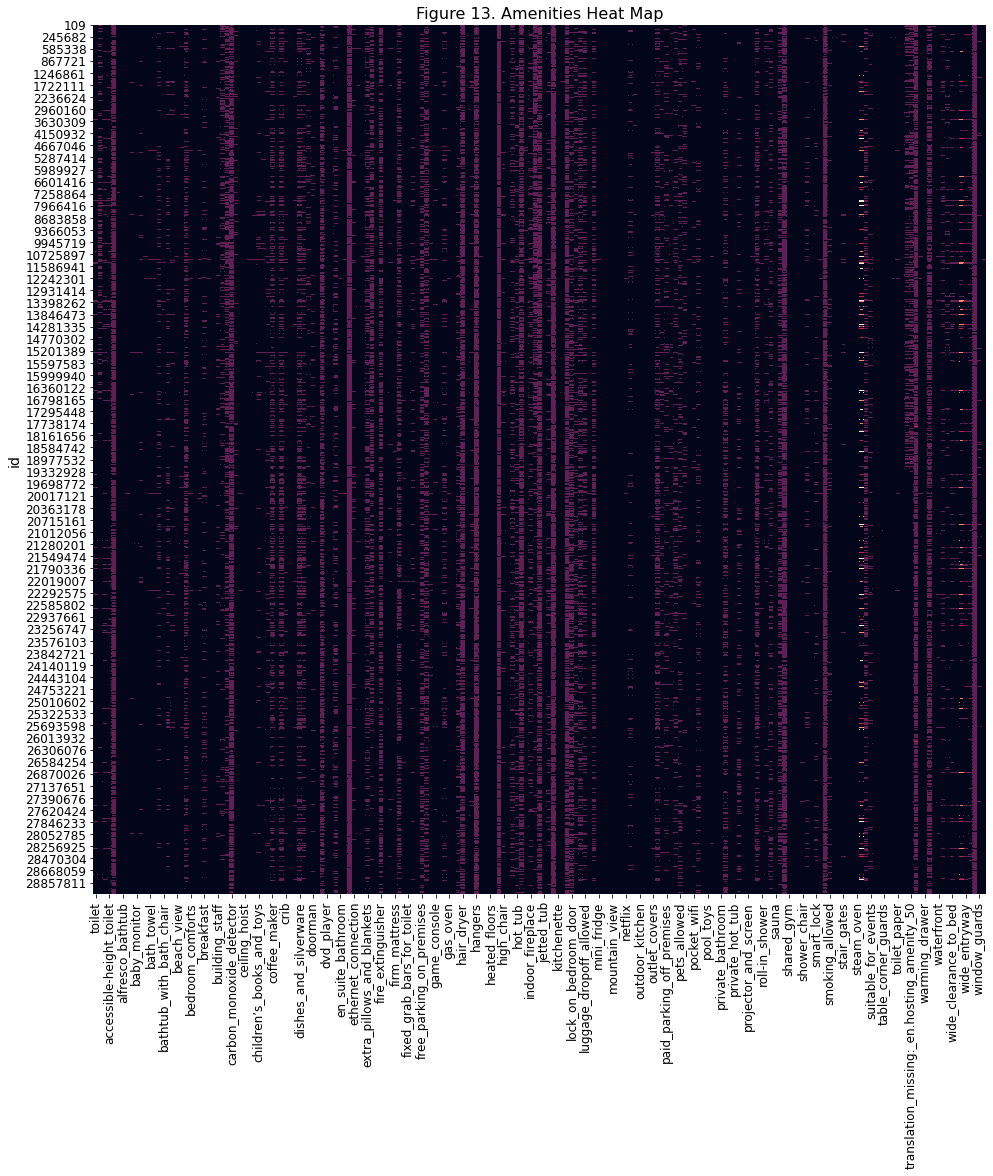

In [0]:
fig13, ax13 = plt.subplots(figsize=(16, 16))
ax13 = sns.heatmap(amenities_df, cbar=False)
ax13.set_title('Figure 13. Amenities Heat Map', fontsize=16);

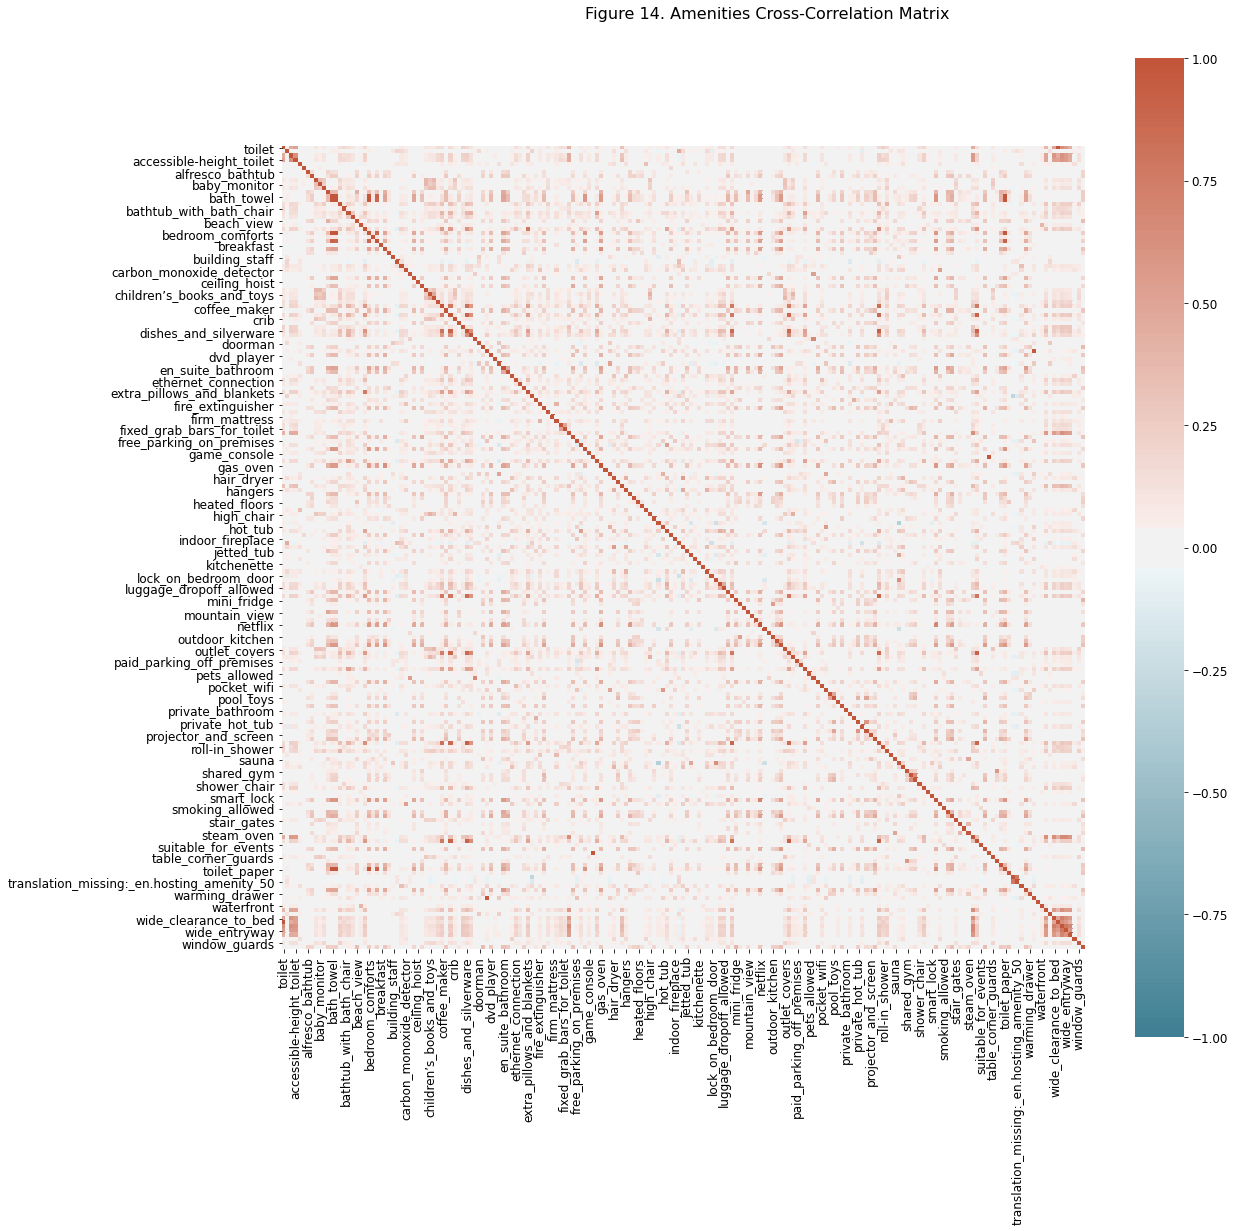

In [0]:
fig14, ax14 = plt.subplots(figsize=(18, 18))
ax14 = sns.heatmap(amenities_df.corr(), ax=ax14,
                   vmin=-1, vmax=1, annot=False, square=True,
                   cmap=sns.diverging_palette(220, 20, n=200))
fig14.suptitle('Figure 14. Amenities Cross-Correlation Matrix', y=0.92);

### Data Preparation Summary

We have performed the following cleaning and feature engineering steps:

- **Delete missing/mismatched values**
  - Drop mismatched dates between Los Angeles and New York calendars
  - Drop listings that were not available for the entire available time interval
  - Drop super-expensive listings above \$20,000 per night
  - Drop listings for which average listing price calculated using **`calendar`** data set is not available
  - Drop 0.2\% of listings with missing numerical feature values
- **Feature Engineering**
  - *`listing_price_bin`*: Median listing price bin: listing median price <= \\$564 and listing median price > \$564 for exploratory analysis
  - *`amenities`*: 197 features  
      
**Output**:
- **`calendar`**: clean data set containing daily availability and pricing per listing
- **`listings`**: clean listings data with generated listing_price_bin and amenities features

## Modeling and Evaluation
In this section we will perform exploratory analysis and price modeling to answer questions we have outlines in the **Business Understanding** section above. 
  
For convenience for the entire section below we will define the level of granularity of the analysis by subgroup for each city and listing median price bins:

In [0]:
subgroups = ['city', 'listing_price_bin']
print('Sub-groups:', subgroups)
print('Price bins:', price_bins)

Sub-groups: ['city', 'listing_price_bin']
Price bins: ['median <= $564.0', 'median > $564.0']


In [0]:
# define which listing features we will examine
size_features = ['accommodates', 'bedrooms', 'bathrooms', 'beds']
type_features = ['property_type', 'room_type']
property_features = size_features + type_features

In this analysis, we focus on comparison of mean values between Los Angeles and New York for a price and listing properties. In order to understand if any observed differences between distribution means are statistically significant, we perform the following statistical tests, based on distribution properties:
- **Very large sample size distributions** - use **Effect Size** tests to estimate significance of observed differences. For large sample sizes, significance testing framework (aka T-test) may result in false positive errors since probability of finding values on far tail-ends (CI>>95% or p-value<<0.05) of a very large sample size are non-negligible. Thus, even small differences between large samples are likely to come up as significant when using t-test simply due to sample size [7]
  - *Non-normal sample distributions* - use **Cliff's delta** [8] test to estimate effect size
  - *Normal sample distributions* - use **Cohen's D** [9] test to estimate effect size
- **Small size distributions**: use significance testing to evaluate significance of observed differences
  - *Normal distributions with equal variances* - use independent t-test [10]
  - *Non-normal distributions with equal variances* - use Kruskal-Wallis H-test [11]
  - *Unequal variances* - use Welch's t-test [12]

Statistical comparison of listing properties between Los Angeles and New York are performed with the use of the following helper functions:

In [0]:
def category_level_pcount(df, column, subgroups, topk=None):
    """Return column category level count as percent of total count for each subgroup
    
    Args:
        df(pd.DataFrame): input dataframe
        column(str): column name for counting category level percentages
        subgroups([str]): list of subgrouping column names
        topk(int): return only topk results for each subgroup
        
    Returns:
        agg(pd.DataFrame): frame containing category level percent counts for each subgroup
    """
    # get subgroup counts
    subgroup_counts = df.groupby(subgroups)[column]\
                        .agg(subgroup_count=(column, 'count'))\
                        .reset_index()
    
    agg = df.groupby(subgroups + [column])[column]\
            .agg(level_count=(column, 'count'))\
            .reset_index()\
            .merge(subgroup_counts, on=subgroups)
    
    agg['level_pcount'] = 100.0 * agg.level_count / agg.subgroup_count
    
    if topk is not None:
        agg = agg.sort_values(subgroups + ['level_pcount'], ascending=False)\
                 .groupby(subgroups).head(topk).set_index(subgroups).reset_index()
    
    return agg

def is_equal_variance(d1, d2, alpha=0.05):
    """Performs stats.levene test on two input distributions.
    
    Args:
        d1, d2(np.array): input distributions
    
    Returns:
        (bool): true if variances between input distributions are equal, false otherwise. 
    """
    # check if variances are equal
    
    W, p = stats.levene(d1, d2)
    if p <= alpha:
        print(f'Group variances are unequal: W={W:.4f}, p={p:.2e}')
        return False
        
    else:
        print(f'Group variances are equal: W={W:.4f}, p={p:.2e}')
        return True

def are_normal(d1, d2, alpha=0.05):
    """Performs stats.normaltest test on two input distributions.
    
    Args:
        d1, d2(np.array): input distributions
    
    Returns:
        (bool): true if variances between input distributions are equal, false otherwise. 
    """
    # Check if group distributions are normal
    
    for d in [d1, d2]:
        k2, p = stats.normaltest(d)
        if p <= alpha:
            print(f'Sample distribution is not normal.')
            return False
    return True


def cohens_d(d1, d2):
    """Return Cohen's D for two normal distributions.
    
    cohens_d = (mean(d1) - mean(d2)) / pooled standard deviation
    
    Interpretations are found at 
    
    Args:
        d1, d2 (np.array): input distributions
        
    Returns:
        cohens_d (float)
        interpretation (str): interpretation of Cohen's D
    """
    
    # calculate the pooled standard deviation
    pooled_std = sqrt(((len(d1) - 1) * d1.var(ddof=1) + (len(d2) - 1) * d2.var(ddof=1)) 
                      / (len(d1) + len(d2) - 2))
    
    # calculate the effect size
    cohens_d = abs(d1.mean() - d2.mean())/ pooled_std
    
    # Interpret cohen's d
    if 0 <= cohens_d < 0.1:
        effect = "very vmall"
    elif 0.1 <= cohens_d < 0.35:
        effect = "small"
    elif 0.35 <= cohens_d < 0.65:
        effect = "medium"
    elif 0.65 <= cohens_d < 0.9:
        effect = "large"
    elif cohens_d >= 0.9:
        effect = "very large"
    
    interpretation = f'Cohen\'s D between groups corresponds to {effect} size.'
    
    return cohens_d, interpretation

def cliffs_delta(d1, d2):
    """Return Cliff's delta for two distributions.
    
    delta =  (# samples(d1 > d2) - # samples(d2 > d1)) / (n1 * n2),
    where n1 and n2 are sample sizes
    
    delta = 2 * U / (n1 * n2) - 1,
    where U is the Mann-Whitney U statistic
    
    Args:
        d1, d2 (np.array)
        
    Returns:
        delta (float): Cliff's delta
        interpretation (str): interpretation of Cliff's delta
    """
    U, p = stats.mannwhitneyu(d1, d2)
    # print(f'Mann-Whitney U={U}, p={p:.2e}')
    delta = abs(2 * U / (len(d1) * len(d2)) - 1)
    
    # Interpret cliff's delta
    if 0 <= delta < 0.2:
        effect = 'small effect'
    elif 0.2 <= delta < 0.4:
        effect = 'medium effect'
    elif delta >= 0.4:
        effect = 'large effect'
    
    interpretation = f'Cliff\'s Delta between group means corresponds to {effect} size.'
    
    return delta, interpretation

def effect_size_test(d1, d2):
    
    normal = are_normal(d1, d2, alpha=0.05)
    
    if normal:
        statistic, interpretation = cohens_d(d1, d2)
    else:   
        statistic, interpretation = cliffs_delta(d1, d2)
    
    return statistic, interpretation

def t_test(d1, d2, alpha=0.05):
    """Perform t-test on two distributions
           Normal and equal variance: independent t-test
           Normal and unequal variance: Welch's t-test
           Non-normal and unequal variance: Welch's t-test
           Non-normal and equal variance: Kruskal-Wallis H-test
    Args:
        d1, d2 (np.array)
        alpha (float): significance level
        
    Returns:
        statistic (float): test statistic
        p (float): marginal significance
        interpretation (str): interpretation of results
    """
    # check of equal variance
    equal_var = is_equal_variance(d1, d2, alpha=alpha)
    
    # check if group values are normally distributed
    normal = are_normal(d1, d2, alpha=alpha)    
    
    # Select appropriate test
    if not normal and not equal_var:
        print('Welch\'s t-test on non-normally distributed groups with unequal variances:')
        statistic, p = stats.ttest_ind(d1, d2, equal_var=equal_var)
    elif not normal and equal_var:
        print('Kruskal-Wallis H-test:')
        statistic, p = stats.kruskal(d1, d2, equal_var=equal_var)
    else:
        print('Independent T-test:')
        statistic, p = stats.ttest_ind(d1, d2, equal_var=equal_var)    
    
    # T-test interpretation 
    significant = 'statistically significant' if p <= alpha else 'not statistically significant'
    interpretation = f'Difference between group means is {significant}.'
    
    return statistic, p, interpretation

def compare_group_means(df, column, group, test='t_test'):
    """Performs group means comparison for 2-level group
       - Test for data normality
       - Test for equal variances between groups
       
         * Effect Size test
             Normal: Cohen's D
             Non-normal: Cliff's delta
    
    Args:
        df (pd.DataFrame): input DataFrame
        column (str): column name for values on for which comparison is performed 
        group (str): grouping column name
        test (str): - 't_test': independent t-test
                    - 'effect_size': cohen's d test for normally distributed data; cliff's delta otherwise

    Returns:
        None
    """
    
    # drop missing and infinite values
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=[column], how='any', axis=0)
    
    # check that group is 2-level
    group_levels = df[group].unique()
    assert len(group_levels) == 2, ('Error: Number of group levels does not equal 2.')
    
    # split data into groups
    gb = df.groupby(group)
    d1, d2 = [gb.get_group(x)[column].to_numpy() for x in gb.groups]
    
    # aggregate statistics
    result_df = gb[column].agg(['count', 'mean', 'median', 'std'])
    display(result_df)
    
    # calculate difference between group means
    diff = result_df['mean'][0] - result_df['mean'][1]
    diffp = 100.0 * abs(diff) / result_df['mean'][0]
    print(f'Difference between groups is {diff:.4f}({diffp:.2f}%)')
         
    # Perform t-test
    if test == 't_test':
        statistic, p, interpretation = t_test(d1, d2, alpha=0.5)
        print(f'{interpretation} Statistic={statistic:.4f}, p-value={p:.2e}')
    elif test == 'effect_size':
        statistic, interpretation = effect_size_test(d1, d2)
        print(f'{statistic:.4f} {interpretation}')
        